<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/master/variational_autoencoder_quality_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Modeling for Quality Assessment

Using a variational auto-encoder we will determine if we can assess an image as high quality or low quality for use in a downstream task.  The hypothesis here is that differences in error when recreating the classes of images may indicate a difference in quality.

## Data Preparation

In [1]:
from google.colab import drive
from zipfile import ZipFile

import shutil

drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy annotated and cropped images imafea
shutil.copy(PARENT_DIR + '/data/Annotated_Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# extract zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Mounted at /content/drive


In [3]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

# get downstream/classification task model files
shutil.copy(PARENT_DIR + '/final_model/transforms.json','transforms.json')
shutil.copy(PARENT_DIR + '/final_model/species_model.pt', 'species_model.pt')
shutil.copy(PARENT_DIR + '/final_model/class_mapping.json', 'class_mapping.json')

device = torch.device('cpu')

with open('class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
model = torch.jit.load('species_model.pt').to(device)
transforms = A.load('transforms.json')

The below functions are used to create a dataset which includes image input for the model but also data that dictates if the image could be classified in the downstream model (1 if classifiable, 0 if not classifiable)

In [4]:
from torch.utils import data
import csv
import random
import torch
import yaml
import os
import shutil
from time import process_time
from torch.utils.data import Dataset

PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 
data_dir = 'RAW/'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def convert_image(img_test):
    image = Image.open(img_test)
    bands = image.getbands()
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    
    # create B&W version
    image_bw = image.resize((512,512))
    image_bw = image_bw.convert('L')
    image_bw = np.expand_dims(image_bw, axis=-1)

    image = np.array(image)
    image = transforms(image=image)['image']
    return image, image_bw

def generate_data_sets(sample_percentage=1):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    seed = 1234
    random.Random(seed).shuffle(subdirectories)
    subdirectories_idx = int(len(subdirectories) * sample_percentage) 
    subdirectories = subdirectories[:subdirectories_idx]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]

        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_name = image_location +'/'+ image
              image_data, image_data_bw = convert_image(image_name)
              model_input = torch.from_numpy(image_data).to(device)
              obs = model_input.permute(2, 0, 1).unsqueeze(dim=0).float()
              y_pred = model(obs)
              y_pred = y_pred.argmax(dim=1).squeeze().item()
              classifiable = 1 if class_index == y_pred else 0
              image_reference = (image_location, image, species, animal_class, image_data_bw, classifiable)
              image_reference_list.append(image_reference)

    train_index = int(len(image_reference_list) * 0.6 )
    test_index = -int(len(image_reference_list) * 0.2 ) 
    val_index = test_index * 2
    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]

    return training, validation, testing



In [5]:
train, validation, test = generate_data_sets(sample_percentage=1)

## Build VAE Model

In [6]:
# clone WildTrack repo to obtain VAE library
!git clone https://github.com/WildTrackAI/wildtrack-iqa.git
!cp wildtrack-iqa/vae/vae.py vae.py

Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 140 (delta 36), reused 28 (delta 21), pack-reused 85
Receiving objects: 100% (140/140), 2.57 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [7]:
import tensorflow as tf
from tensorflow import keras
import vae
from vae import VAE

encoder = vae.create_encoder()
decoder = vae.create_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00000001))

In [8]:
# confirm network structure for encoding images
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

In [9]:
# confirm network structure for decoding images
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 1048576)           105906176 
                                                                 
 reshape (Reshape)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     4160      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 512, 512, 32)     2080      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 1)       33  

## Model Training

In [10]:
# Prepare training data. Train on only data we know will be classifiable so that it can recognize unclassifiable images as an anomaly

X_train = np.array([item[4] for item in train])
y_train = np.array([item[5] for item in train])

X_val = np.array([item[4] for item in validation])
y_val = np.array([item[5] for item in validation])

X_test = np.array([item[4] for item in test])
y_test = np.array([item[5] for item in test])

X_usable_train, X_reject_train = X_train[y_train == 1], X_train[y_train == 0]
X_usable_val, X_reject_val = X_val[y_val == 1], X_val[y_val == 0]
X_usable_test, X_reject_test = X_test[y_test == 1], X_test[y_test == 0]

In [11]:
# Train the autoencoder
from tensorflow.keras.callbacks import EarlyStopping

# We pass the same value for x and y because we want to recreate the input, Basically f(x) = x
tf_train = tf.data.Dataset.from_tensor_slices((X_usable_train, X_usable_train)).batch(64)
tf_val = tf.data.Dataset.from_tensor_slices((X_usable_val, X_usable_val)).batch(64)
tf_test = tf.data.Dataset.from_tensor_slices((X_usable_test, X_usable_test)).batch(64)

earlystopper = EarlyStopping(monitor='val_total_loss', mode='min', min_delta=0.000001, patience=5, verbose=0, restore_best_weights=True)
max_epochs = 10
hist = vae.fit(tf_train, epochs=max_epochs,  shuffle=True, callbacks=[earlystopper], validation_data=tf_val)
model_path = 'vae_model'
os.mkdir(model_path)
vae.save_model(model_path)

Epoch 1/10
30/30 [==============================] - 90s 3s/step - total_loss: 6215848.5000 - reconstruction_loss: 6215848.5000 - kl_loss: 7.4220e-04 - val_total_loss: 541221.3750 - val_reconstruction_loss: 541221.3750 - val_kl_loss: 0.0014
Epoch 2/10
30/30 [==============================] - 87s 3s/step - total_loss: 6215851.5000 - reconstruction_loss: 6215851.5000 - kl_loss: 7.2729e-04 - val_total_loss: 541210.2500 - val_reconstruction_loss: 541210.2500 - val_kl_loss: 0.0013
Epoch 3/10
30/30 [==============================] - 86s 3s/step - total_loss: 6215846.5000 - reconstruction_loss: 6215846.5000 - kl_loss: 7.1362e-04 - val_total_loss: 541214.1250 - val_reconstruction_loss: 541214.1250 - val_kl_loss: 0.0013
Epoch 4/10
30/30 [==============================] - 86s 3s/step - total_loss: 6215846.5000 - reconstruction_loss: 6215846.5000 - kl_loss: 7.0075e-04 - val_total_loss: 541223.5000 - val_reconstruction_loss: 541223.5000 - val_kl_loss: 0.0013
Epoch 5/10
30/30 [======================

In [12]:
X_sample_test = X_test[0:300]
y_sample_test = y_test[0:300]
z_mean, z_log_var = vae.encoder(X_sample_test)
sample = vae.sampler(z_mean, z_log_var)
decoded = vae.decoder(sample)

mse = np.mean(np.power(X_sample_test - decoded, 2), axis=1)
sum_mse = np.array([np.matrix(item).sum() for item in mse])

## Data Analysis

The goal is to assess the mean squared error when attempting to recreate the image, separated by data that could be classified by the model vs data that could not be classified (noted as 1 and 0 respectively). 

In [13]:
import pandas as pd

# swap quality class 1 - bad quality, 0 quality

y_sample_test_class = [ 1 if x == 0 else 0 for x in y_sample_test]

# gather the mean square error calculated from the model and align with classification ability
error_df_test = pd.DataFrame({'mse': sum_mse, 'class': y_sample_test_class})
error_df_test.describe()

,mse,class
count,3.000000e+02,300.000000
mean,9.404026e+06,0.300000
std,2.414361e+06,0.459023
min,1.385071e+06,0.000000
25%,8.055405e+06,0.000000
50%,9.660771e+06,0.000000
75%,1.125168e+07,1.000000
max,1.439389e+07,1.000000


In [14]:
# group data by classification and calculate basic statistics for mse
group_calculation = error_df_test[['mse','class']].groupby("class").describe()
group_calculation

mse                                                              \
       count       mean         std          min          25%        50%   
class                                                                      
0      210.0  9549262.0  2491526.25  2055473.875  8177405.875  9851384.0   
1       90.0  9065140.0  2199940.25  1385071.375  7768654.125  9244815.5   

                                
               75%         max  
class                           
0      11431434.50  14393890.0  
1      10802412.75  13922002.0

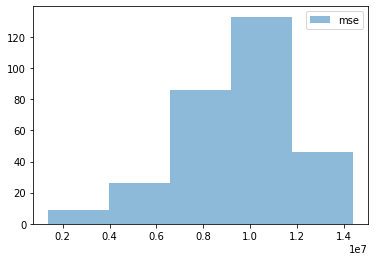

In [15]:
plt.hist(error_df_test['mse'], bins=5, alpha=0.5, label='mse')
plt.legend(loc='upper right')
plt.show()

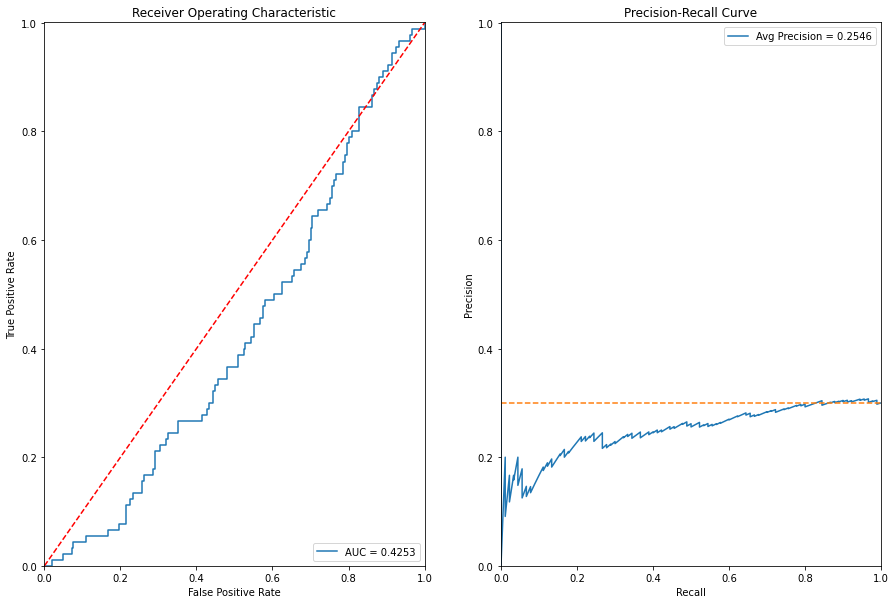

In [16]:
# Create a ROC and Precision Curve to assess how well we can claassify based on mse

from sklearn.metrics import confusion_matrix , roc_auc_score, roc_curve, auc, classification_report, average_precision_score, precision_recall_curve

fpr, tpr, thresholds = roc_curve(error_df_test['class'], error_df_test['mse'])
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(error_df_test['class'], error_df_test['mse'])
avg_pr = average_precision_score(error_df_test['class'], error_df_test['mse'])

no_skill = len(error_df_test['class'][error_df_test['class']==1]) / len(error_df_test['class'])

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Receiver Operating Characteristic')
axs[0].plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
axs[0].legend(loc='lower right')
axs[0].plot([0,1],[0,1],'r--')
axs[0].set_xlim([-0.001, 1])
axs[0].set_ylim([0, 1.001])
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')

axs[1].set_title('Precision-Recall Curve')
axs[1].plot(recall, precision, label='Avg Precision = %0.4f'% avg_pr)
axs[1].legend(loc='upper right')
axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1].set_xlim([-0.001, 1])
axs[1].set_ylim([0, 1.001])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('Recall')
plt.show();

AUC indicates that prediction is better than average overall, with a precision of .78 . So this method may have some validity

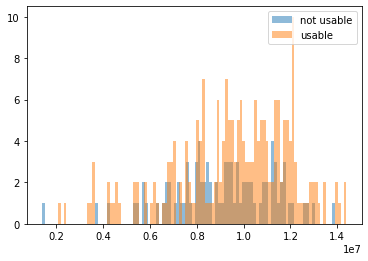

In [17]:
# Graph data to see if there is a clear threshold revealed between clasifiable non-classifiable images

classifiable = error_df_test[(error_df_test['class'] == 0)].mse.values
not_classifiable = error_df_test[(error_df_test['class'] == 1)].mse.values

plt.hist(not_classifiable, bins=100, alpha=0.5, label='not usable')
plt.hist(classifiable, bins=100, alpha=0.5, label='usable')
plt.legend(loc='upper right')
plt.show()


There is significant overlap except for data that has an mse higher than 3.8e7. We'll dig a bit deeper to determine what is the best threshold to use for both precision and recall when determining high quality images.

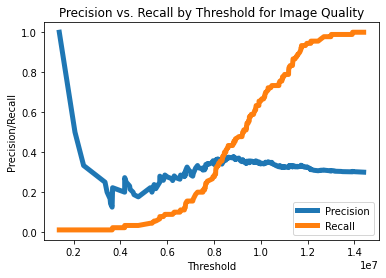

In [18]:
import warnings
warnings.filterwarnings("ignore")

#Let's evaluate for best threshold using precision/recall measures
precisions = []
recalls = []

for threshold in thresholds:
  predictions = [0 if x > threshold else 1 for x in error_df_test["mse"]]
  classification = classification_report(error_df_test["class"], predictions, output_dict=True)['1']
  precisions.append(classification['precision'])
  recalls.append(classification['recall'])

plt.plot(thresholds, precisions, label="Precision",linewidth=5)
plt.plot(thresholds, recalls, label="Recall",linewidth=5)
plt.title('Precision vs. Recall by Threshold for Image Quality')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The optimal threshold to use for prediction is the point where both precision and recall are at it's best.  In reviewing the above chart this appears at approximately mse 2.5e7. For predictions we will use that to identify high quality images vs low quality and review the results

In [19]:
predictions = [0 if x > 0.82e7 else 1 for x in error_df_test["mse"]]

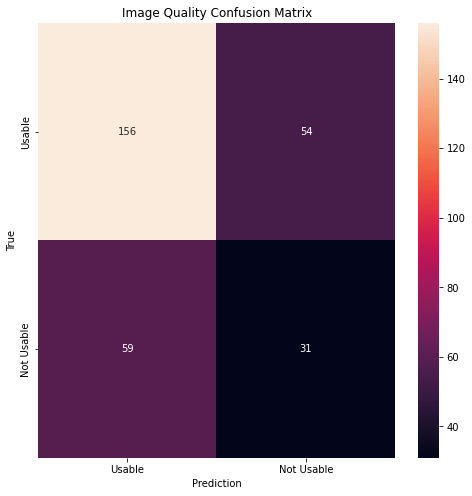

In [20]:
import seaborn as sns
labels = ["Usable","Not Usable"]
conf_matrix = confusion_matrix(error_df_test['class'],predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Image Quality Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Prediction')
plt.show()

In [21]:
print(classification_report(error_df_test["class"], predictions))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       210
           1       0.36      0.34      0.35        90

    accuracy                           0.62       300
   macro avg       0.55      0.54      0.54       300
weighted avg       0.62      0.62      0.62       300



The overall accuracy in this method is 61% accuracy in determining whether something is truly classifiable or not.  F1 Scores indicate it is better at determining when something is high quality vs not.
 